## 1. Imports

In [1]:
import wandb
import copy
import torch
import json
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pytorch_datasets import SentimentAnalysisDataset, DatasetType
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [2]:
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
model_name_wandb = "cardiffnlp_twitter-xlm-roberta-base-sentiment" # has to be without slash
label_arrangement = ["Negative", "Neutral", "Positive"]

## 2. Model config

In [3]:
# Load json file with hyperparams of each model
with open('../hyperparams.json') as file:
    hyper_params = json.load(file)

In [4]:
# Set up Hyper parameters for model training
LR: float = hyper_params[model_name]["lr"]
OPTIMIZER: str = hyper_params[model_name]["optimizer"]
EPOCHS: int = hyper_params[model_name]["epochs"]
BATCH_SIZE: int = hyper_params[model_name]["batch_size"]
DROPOUT: float = hyper_params[model_name]["dropout"]

## 3. Dataframe preperations

In [5]:
df = pd.read_excel("../../../data/wsb_annotations/wsb_annotations_final.xlsx", sheet_name="final_annotations")

In [6]:
df.drop(columns=["stock_symbol"], inplace=True)

In [7]:
df["label"].value_counts(normalize=True)

2    0.386
1    0.316
0    0.298
Name: label, dtype: float64

## 4. Model Loading

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
model

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

## 5. Building Pytorch Dataset

In [10]:
# Declare generic sentiment analysis dataset without split
sentiment_analysis_dataset = SentimentAnalysisDataset(
    df = df,
    tokenizer = tokenizer,
    max_token_len = 256,
    label_arrangement = label_arrangement
)

In [11]:
# Declare train and test dataset
train_dataset = copy.deepcopy(sentiment_analysis_dataset).set_fold(DatasetType.TRAIN)
test_dataset = copy.deepcopy(sentiment_analysis_dataset).set_fold(DatasetType.TEST)

In [12]:
# Setup train and test Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=1,
                                                drop_last=True
                                                )

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=1,
                                               drop_last=True
                                              )

In [13]:
train_dataset.__len__()

800

In [14]:
test_dataset.__len__()

200

In [15]:
# Check if train data and test data have correct batch and tensor sizes
"""print('TRAINING DATA:')
for dictionary in train_data_loader:
    print(dictionary)
    break"""

print(' ')
print('TESTING DATA:')
for dictionary in test_data_loader:
    print(dictionary["labels"].size())
    break

 
TESTING DATA:
torch.Size([32, 3])


## 7. Model Evaluation

In [16]:
# pull data from test dataloader to have one batch

# labels
y_true = torch.cat(tuple(data["labels"] for data in test_data_loader), dim=0).numpy().astype(int)

# ids, mask, token_type_ids
ids = torch.cat(tuple(data["input_ids"] for data in test_data_loader), dim=0)
mask = torch.cat(tuple(data["attention_mask"] for data in test_data_loader), dim=0)
token_type_ids = torch.cat(tuple(data["token_type_ids"] for data in test_data_loader), dim=0)

In [17]:
y_true

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1,

In [18]:
# One last forward pass to evaluate the model
with torch.no_grad():
    outputs = model(ids, mask, token_type_ids)
    y_pred = F.one_hot(torch.argmax(outputs.logits, dim=1), num_classes=3).numpy()
    print(y_pred)

# need one more epoch before training -> epoch 0
# need to save model to wandb or else
# get confusion matrices right and lof them to wandb


[[0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 

In [19]:
# Calculate accuracy, precision, recall and f1-score with micro average
prec_avg = precision_score(y_true=y_true, y_pred=y_pred, average="micro")
recall_avg = recall_score(y_true=y_true, y_pred=y_pred, average="micro")
f1_avg = f1_score(y_true=y_true, y_pred=y_pred, average="micro")
accuracy = (np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1)).sum() / len(y_pred)

In [20]:
f1_avg

0.4479166666666667

In [21]:
(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1)).sum() / len(y_pred)

0.4479166666666667

## 8. WANDB Log data

In [22]:
# Initialize WAND tracking
config = wandb.config = {
    "model_name": model_name_wandb,
    "type": "pretrained model"
}

run = wandb.init(project="Bachelor-Thesis", entity="hda_sis", config=config, name=model_name_wandb)

wandb: Currently logged in as: jan_burger (hda_sis). Use `wandb login --relogin` to force relogin


In [23]:
wandb.log({"Precision Avg": prec_avg,
           "Recall Avg": recall_avg,
           "F1-Score Avg": f1_avg,
           "Accuracy": accuracy
           })

In [24]:
y_true_argmax = np.argmax(y_true, axis=1)
y_pred_argmax = np.argmax(y_pred, axis=1)

In [25]:
print(y_true_argmax, y_pred_argmax)

[1 1 0 2 1 0 2 0 1 2 0 2 0 0 2 1 0 0 2 2 1 0 1 1 1 2 1 0 2 1 2 2 0 1 0 1 1
 1 0 2 0 2 1 2 0 0 1 1 0 1 1 1 2 0 1 0 2 2 0 0 2 2 1 0 2 0 2 1 2 2 2 1 2 2
 0 2 2 0 0 2 2 2 2 1 0 2 1 2 1 2 2 1 1 2 2 1 2 0 2 1 1 1 2 2 2 2 1 0 2 2 0
 2 2 2 0 2 2 2 2 2 1 1 2 1 1 0 0 0 0 0 0 2 0 1 1 1 2 1 2 1 2 0 1 0 1 2 1 0
 1 0 0 1 1 0 0 1 2 0 0 0 2 0 2 1 0 0 2 2 1 1 1 1 2 2 2 0 2 0 2 1 0 0 2 0 2
 1 0 1 2 1 2 1] [2 1 0 1 1 0 0 1 1 1 0 2 0 1 0 0 2 0 2 2 1 0 1 0 0 2 1 1 2 1 2 1 1 1 0 1 0
 1 1 1 1 1 1 1 2 0 1 0 0 1 2 0 0 2 1 1 2 1 0 0 2 1 0 1 1 0 1 0 1 2 0 1 2 2
 1 1 0 1 1 1 0 0 0 1 0 0 0 2 0 0 0 2 1 1 0 1 2 1 2 2 1 0 2 0 1 0 1 0 1 1 0
 1 0 2 0 1 2 1 2 0 0 0 2 0 0 0 1 2 0 0 0 1 1 0 0 1 1 1 2 0 0 1 1 1 1 1 2 0
 0 0 0 0 1 0 1 0 1 1 0 2 1 0 1 1 0 1 1 1 0 1 0 0 2 2 2 1 1 0 0 0 0 0 2 0 2
 0 0 1 0 0 2 0]


In [26]:
# Create raw and normalized confusion matrices
cm_raw = confusion_matrix(y_true_argmax, y_pred_argmax, labels=[0,1,2])
cm_normalized = np.round(cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis], decimals=2)

In [27]:
cm_raw

array([[32, 20,  5],
       [28, 28,  5],
       [19, 29, 26]], dtype=int64)

In [28]:
cm_normalized

array([[0.56, 0.35, 0.09],
       [0.46, 0.46, 0.08],
       [0.26, 0.39, 0.35]])

### Plot confusion matrices micro averaged

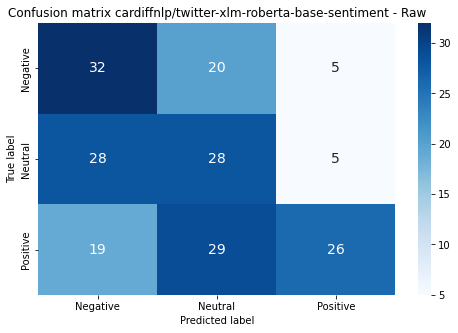

In [29]:
# Create confusion matrices with seaborn

# Raw Confusion matrix
df_cm_raw = pd.DataFrame(cm_raw, columns=label_arrangement, index=label_arrangement)
df_cm_raw.index.name = "True label"
df_cm_raw.columns.name = "Predicted label"
plt.figure(figsize=(8, 5))
plt.title(f"Confusion matrix {model_name} - Raw")
plot_cm_raw = sns.heatmap(
    df_cm_raw, cmap="Blues", annot=True, annot_kws={"size": 14}
)  # font size

# Log raw confusion matrix to wandb
wandb.log({"Confusion matrix - Raw": wandb.Image(plot_cm_raw)})

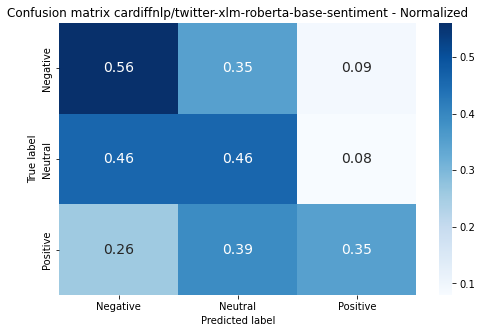

In [30]:
# Normalized Confusion matrix
df_cm_norm = pd.DataFrame(cm_normalized, columns=label_arrangement, index=label_arrangement)
df_cm_norm.index.name = "True label"
df_cm_norm.columns.name = "Predicted label"
plt.figure(figsize=(8, 5))
plt.title(f"Confusion matrix {model_name} - Normalized")
plot_cm_norm = sns.heatmap(
    df_cm_norm, cmap="Blues", annot=True, annot_kws={"size": 14}
)  # font size

# Log normalized confusion matrix to wandb
wandb.log({"Confusion matrix - Normalized": wandb.Image(plot_cm_norm)})

In [31]:
wandb.finish()

Accuracy,▁
F1-Score Avg,▁
Precision Avg,▁
Recall Avg,▁
Accuracy,0.44792
F1-Score Avg,0.44792
Precision Avg,0.44792
Recall Avg,0.44792


In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-xlm-roberta-base-sentiment")

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

In [2]:
model.config


XLMRobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-xlm-roberta-base-sentiment",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Negative",
    "1": "Neutral",
    "2": "Positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

In [3]:
batch = tokenizer(["Covid cases are increasing fast!"], padding=True, truncation=True, max_length=256, return_tensors="pt", add_special_tokens=True)

In [38]:
batch = tokenizer.encode_plus(
    "Stocks only go up",
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    return_token_type_ids=True,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

In [4]:
batch

{'input_ids': tensor([[     0,   1311,   5518,  50218,    621, 118055,   4271,     38,      2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [6]:
with torch.no_grad():
    outputs = model(**batch)
    print(outputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
    print(predictions)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.3277,  0.1502, -0.9750]]), hidden_states=None, attentions=None)
tensor([[0.4741, 0.3970, 0.1289]])


In [5]:
import torch

In [57]:
torch.unsqueeze(ids[0], dim=0).size()

torch.Size([1, 256])

In [51]:
ids.size()

torch.Size([192, 256])

In [53]:
with torch.no_grad():
    outputs = model(ids[0:100], mask[0:100], token_type_ids[0:100])
    print(outputs)
    predictions = F.softmax(outputs.logits, dim=1)
    print(predictions)

IndexError: index out of range in self

In [60]:
try:
    for i in range(len(ids)):
        outputs = model(torch.unsqueeze(ids[i], dim=0),
                        torch.unsqueeze(mask[i], dim=0),
                        torch.unsqueeze(token_type_ids[i], dim=0))
except Exception as e:
    print(torch.unsqueeze(ids[i], dim=0))
    print(torch.unsqueeze(mask[i], dim=0))
    print(torch.unsqueeze(token_type_ids[i], dim=0))

tensor([[    0,  6630,  1061,  9731,     4,   180,    25,  4754,  5946,    86,
            31,   226,  6002,    30, 19302, 22717, 24236,  2124,   520,     7,
           367,    52, 17869,   634,  2463, 33271,  2416,  1928,  7242,  2857,
             9,  2084,  6377, 32188,  4852,    43, 42325,   783,  2603, 15402,
           471, 15026,   256,    86,    31,    11,    94,  1470,   137,   133,
          7204, 17869, 19302, 22717,    16,  4527,    52,    14,  5748, 23836,
             3,  5368,  5368,   906, 16616, 21654,  1554,  1043,     3,   205,
         48425, 34287,     9, 37008,   268, 14058,   685, 18296,     7, 39397,
            13,  6519,   879,     7,    32,    14,   169,     6,  1329, 43964,
            20,  9327,   527, 10994,    48, 11787, 42747, 53058,   423,    60,
            72,    17,    18,  4548, 35530, 38370,  1250,   208,    19, 14317,
           121, 19295,   836,   543, 17742,   612,  1364,   429,  3582,  1847,
         50239, 50239,     3,   458,  5664, 32059,  

In [64]:
max(ids[i])

tensor(53058)

In [68]:
model.config

RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.19.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 64001
}